In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import (GlobalAveragePooling2D, Flatten, Dense, Dropout,
                          BatchNormalization)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

In [18]:
# === 路径配置 ===
WORK_DIR = '../Datasets/cassava-leaf-disease-classification/'
TRAIN_IMAGES_PATH = os.path.join(WORK_DIR, "train_images")

# === 可视化参数 ===
CLASS_DICT = {
    0: 'CBB',
    1: 'CBSD',
    2: 'CGM',
    3: 'CMD',
    4: 'Healthy'
}
PLOT_DPI = 120
SUBPLOT_LAYOUT = (2, 3)  # 样本展示布局

# 统一 BATCH_SIZE、EPOCHS 等超参数
BATCH_SIZE = 8
EPOCHS = 15
IMG_SIZE = 512
N_CLASS = 5

In [21]:
def load_dataset(show_stats=True):
    """加载并分割数据集"""
    try:
        df = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
        
        # 数据验证
        assert 'image_id' in df.columns, "缺少image_id列"
        assert 'label' in df.columns, "缺少label列"
        
        # 分层划分
        train_df, test_df = train_test_split(
            df,
            test_size=0.1, 
            random_state=42,
            stratify=df['label']
        )
        
        if show_stats:
            print("📊 数据集统计：")
            print(f"- 总样本数：{len(df):,}")
            print(f"- 训练集：{len(train_df):,} (90%)")
            print(f"- 测试集：{len(test_df):,} (10%)")
            print("\n🔢 类别分布：")
            print(Counter(df['label']))
            
        return df, train_df, test_df
    
    except Exception as e:
        print(f"❌ 数据加载失败：{str(e)}")
        return None, None, None  # 如果失败，返回三个 None

# 执行加载
df, train_df, test_df = load_dataset()
if df is None or train_df is None or test_df is None:
    raise SystemExit("数据加载失败，停止执行。")

# 应用映射，增加可视化列
df['label_name'] = df['label'].map(CLASS_DICT)


📊 数据集统计：
- 总样本数：21,397
- 训练集：19,257 (90%)
- 测试集：2,140 (10%)

🔢 类别分布：
Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


/var/folders/1q/mrjhh9gs1d30n7xqh9rm1nxm0000gn/T/ipykernel_46695/772945499.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


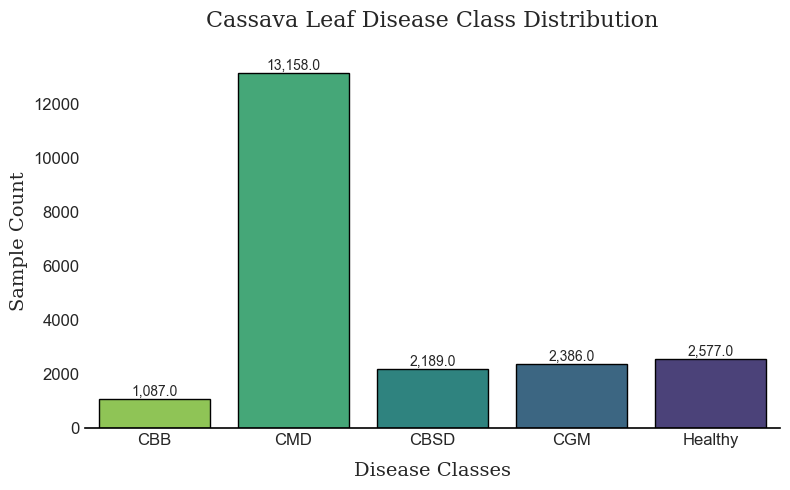

In [22]:
# === 可视化：类别统计 ===
plt.figure(figsize=(8, 5), dpi=100)
sns.set_style("whitegrid", {'axes.grid': False})
ax = sns.countplot(
    x='label_name', 
    data=df,  
    edgecolor='black',
    palette=reversed(sns.color_palette("viridis", df['label_name'].nunique()))
)
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines['bottom'].set(color='black', linewidth=1.2)

ax.set_xlabel('Disease Classes', 
              fontfamily='serif', 
              fontsize=14,
              labelpad=10)
ax.set_ylabel('Sample Count', 
              fontfamily='serif',
              fontsize=14)
ax.tick_params(axis='both', which='major', 
               labelsize=12, 
               length=0)

# 添加数据标签
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10)

plt.title("Cassava Leaf Disease Class Distribution", 
          fontfamily='serif',
          fontsize=16,
          pad=20)
plt.tight_layout()
plt.savefig("class_distribution.png", bbox_inches='tight')
plt.show()

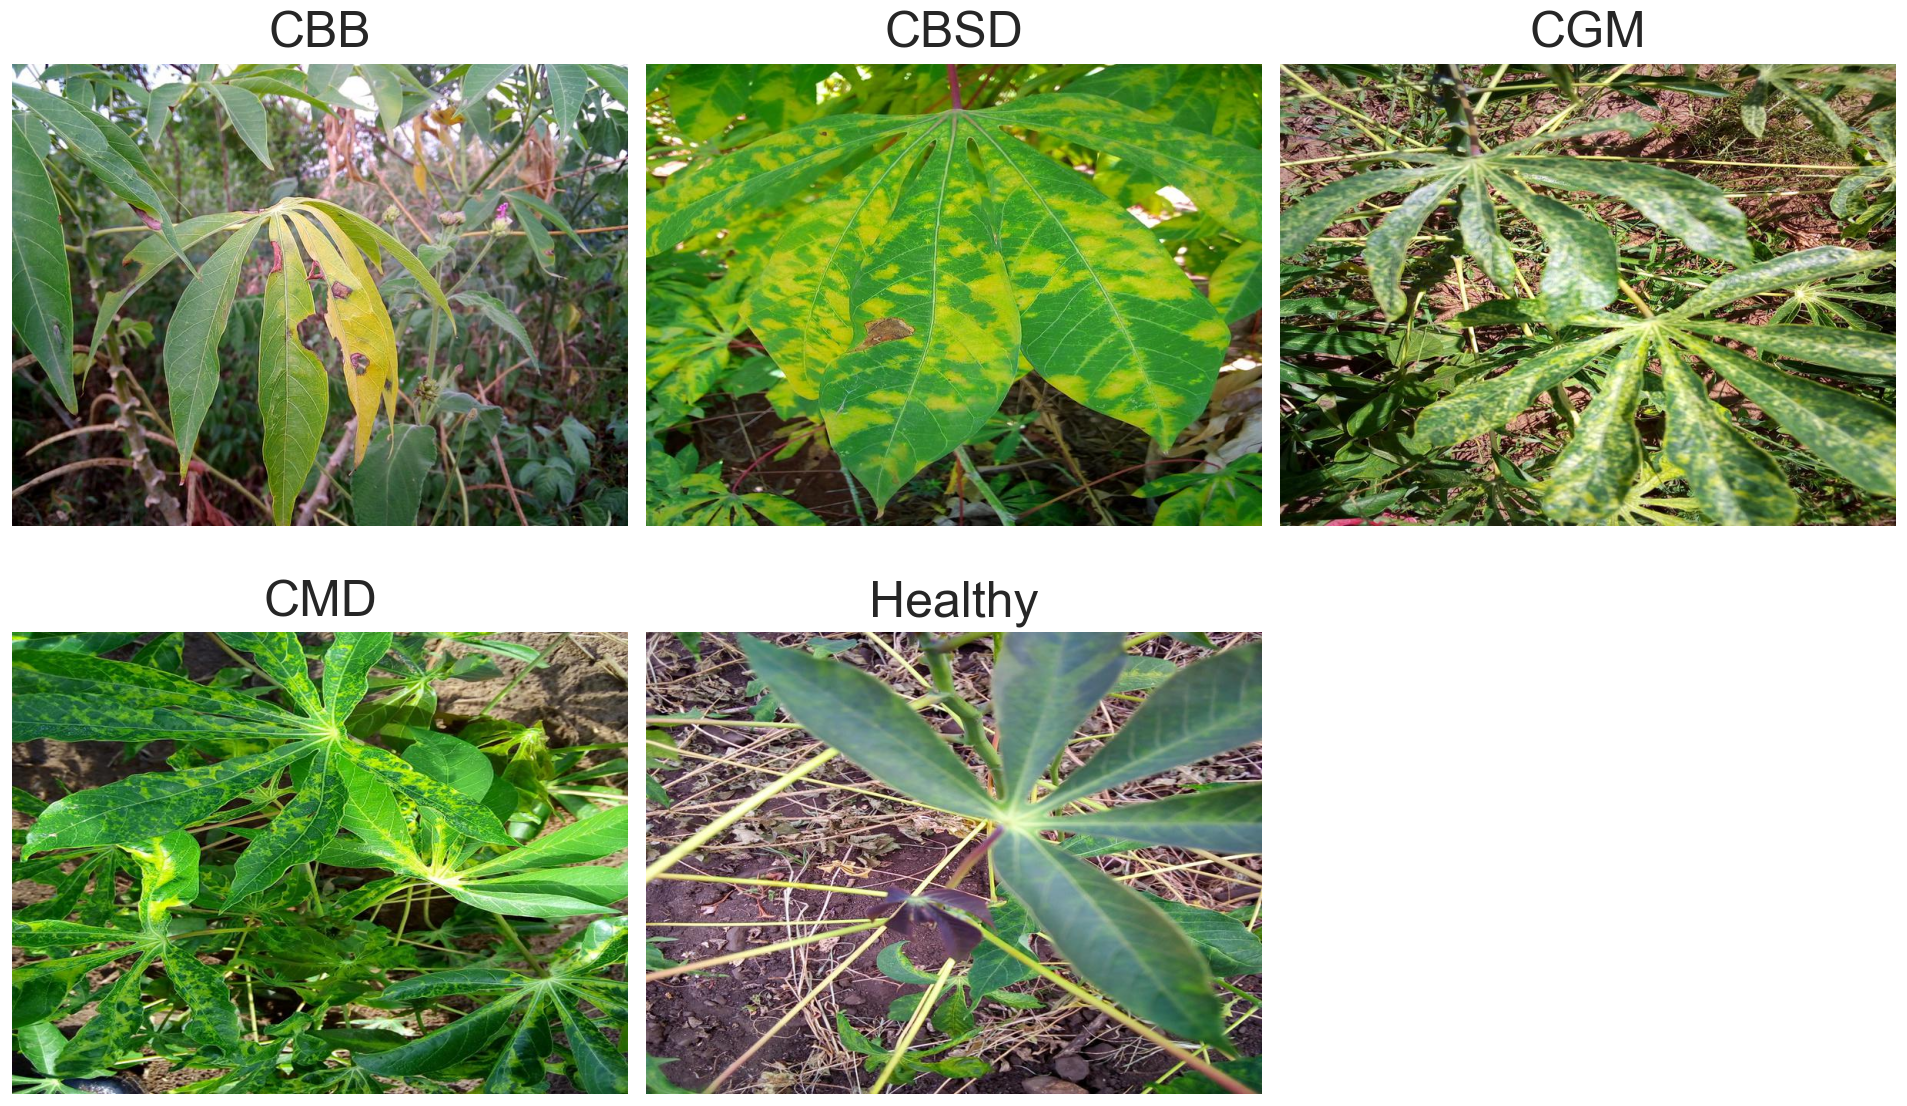

In [24]:
# === 样本展示函数 ===
def display_samples(dataframe):
    """展示每个类别的首个图像样本"""
    fig, axes = plt.subplots(*SUBPLOT_LAYOUT, figsize=(16, 10), dpi=PLOT_DPI)
    
    for idx, (class_id, class_name) in enumerate(CLASS_DICT.items()):
        # 过滤对应类别的样本
        samples = dataframe[dataframe['label'] == class_id]
        
        if samples.empty:
            print(f"⚠️ Class {class_id} ({class_name}) has no samples")
            continue
        
        # 查找首个有效图像
        img_shown = False
        for _, row in samples.iterrows():
            img_path = os.path.join(TRAIN_IMAGES_PATH, str(row['image_id']))
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path)
                    row_idx = idx // SUBPLOT_LAYOUT[1]
                    col_idx = idx % SUBPLOT_LAYOUT[1]
                    
                    axes[row_idx, col_idx].imshow(img)
                    axes[row_idx, col_idx].set_title(
                        f"{class_name}", 
                        fontsize=30,                    
                        pad=10
                    )
                    axes[row_idx, col_idx].axis('off')
                    img_shown = True
                    break
                except Exception as e:
                    print(f"⚠️ 加载失败：{img_path} - {str(e)}")
        
        if not img_shown:
            print(f"⚠️ No valid images found for {class_name}")

    # 清理空白子图（如果 CLASS_DICT 的数量不足以填满子图布局）
    total_classes = len(CLASS_DICT)
    for ax in axes.flat[total_classes:]:
        ax.remove()
    
    plt.tight_layout()
    plt.savefig("sample_preview.png", bbox_inches='tight')
    plt.show()
    
# 展示训练集的示例
display_samples(train_df)

In [25]:
# === 数据预处理与增广 ===
train_df['label'] = train_df['label'].astype(str)  # for ImageDataGenerator
test_df['label'] = test_df['label'].astype(str)    # 同上

# 训练集与验证集的图像生成器
datagen_train = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

# ⚠ 注意：使用 subset="training"/"validation" 时，DataFrame 要是同一个
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGES_PATH,
    x_col="image_id",
    y_col="label",
    subset="training",
    seed=42,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size=BATCH_SIZE
)

validation_generator = datagen_val.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGES_PATH,
    x_col="image_id",
    y_col="label",
    subset="validation",
    seed=42,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size=BATCH_SIZE
)

# 测试集（单独）
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=TRAIN_IMAGES_PATH,
    x_col="image_id",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # 测试集一般不需要乱序
    interpolation='nearest'
)

Found 15406 validated image filenames belonging to 5 classes.
Found 3851 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


Found 1 validated image filenames belonging to 1 classes.


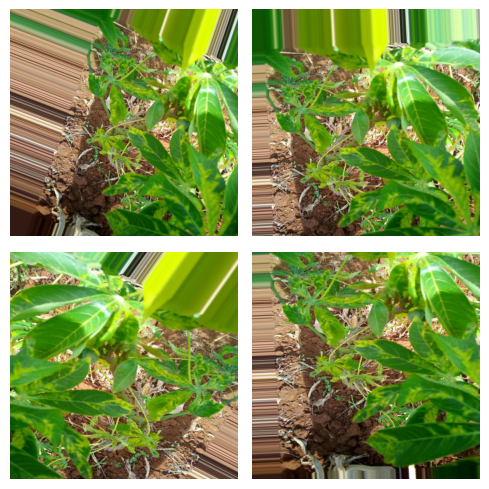

In [26]:
# === 增强后的可视化展示（仅演示） ===
viz_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# 这里仅拿 train_df 的第8行做演示
viz_generator = viz_datagen.flow_from_dataframe(
    train_df.iloc[7:8],
    directory=TRAIN_IMAGES_PATH,
    x_col="image_id",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

aug_images = []
for _ in range(4):
    batch = next(viz_generator)[0]
    img_aug = batch[0]  # 取出单张图
    aug_images.append(img_aug / 255.0)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.savefig("image_after_augmentation.png")
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 16, 16, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,292 (42.64 MB)

 Trainable params: 11,090,989 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

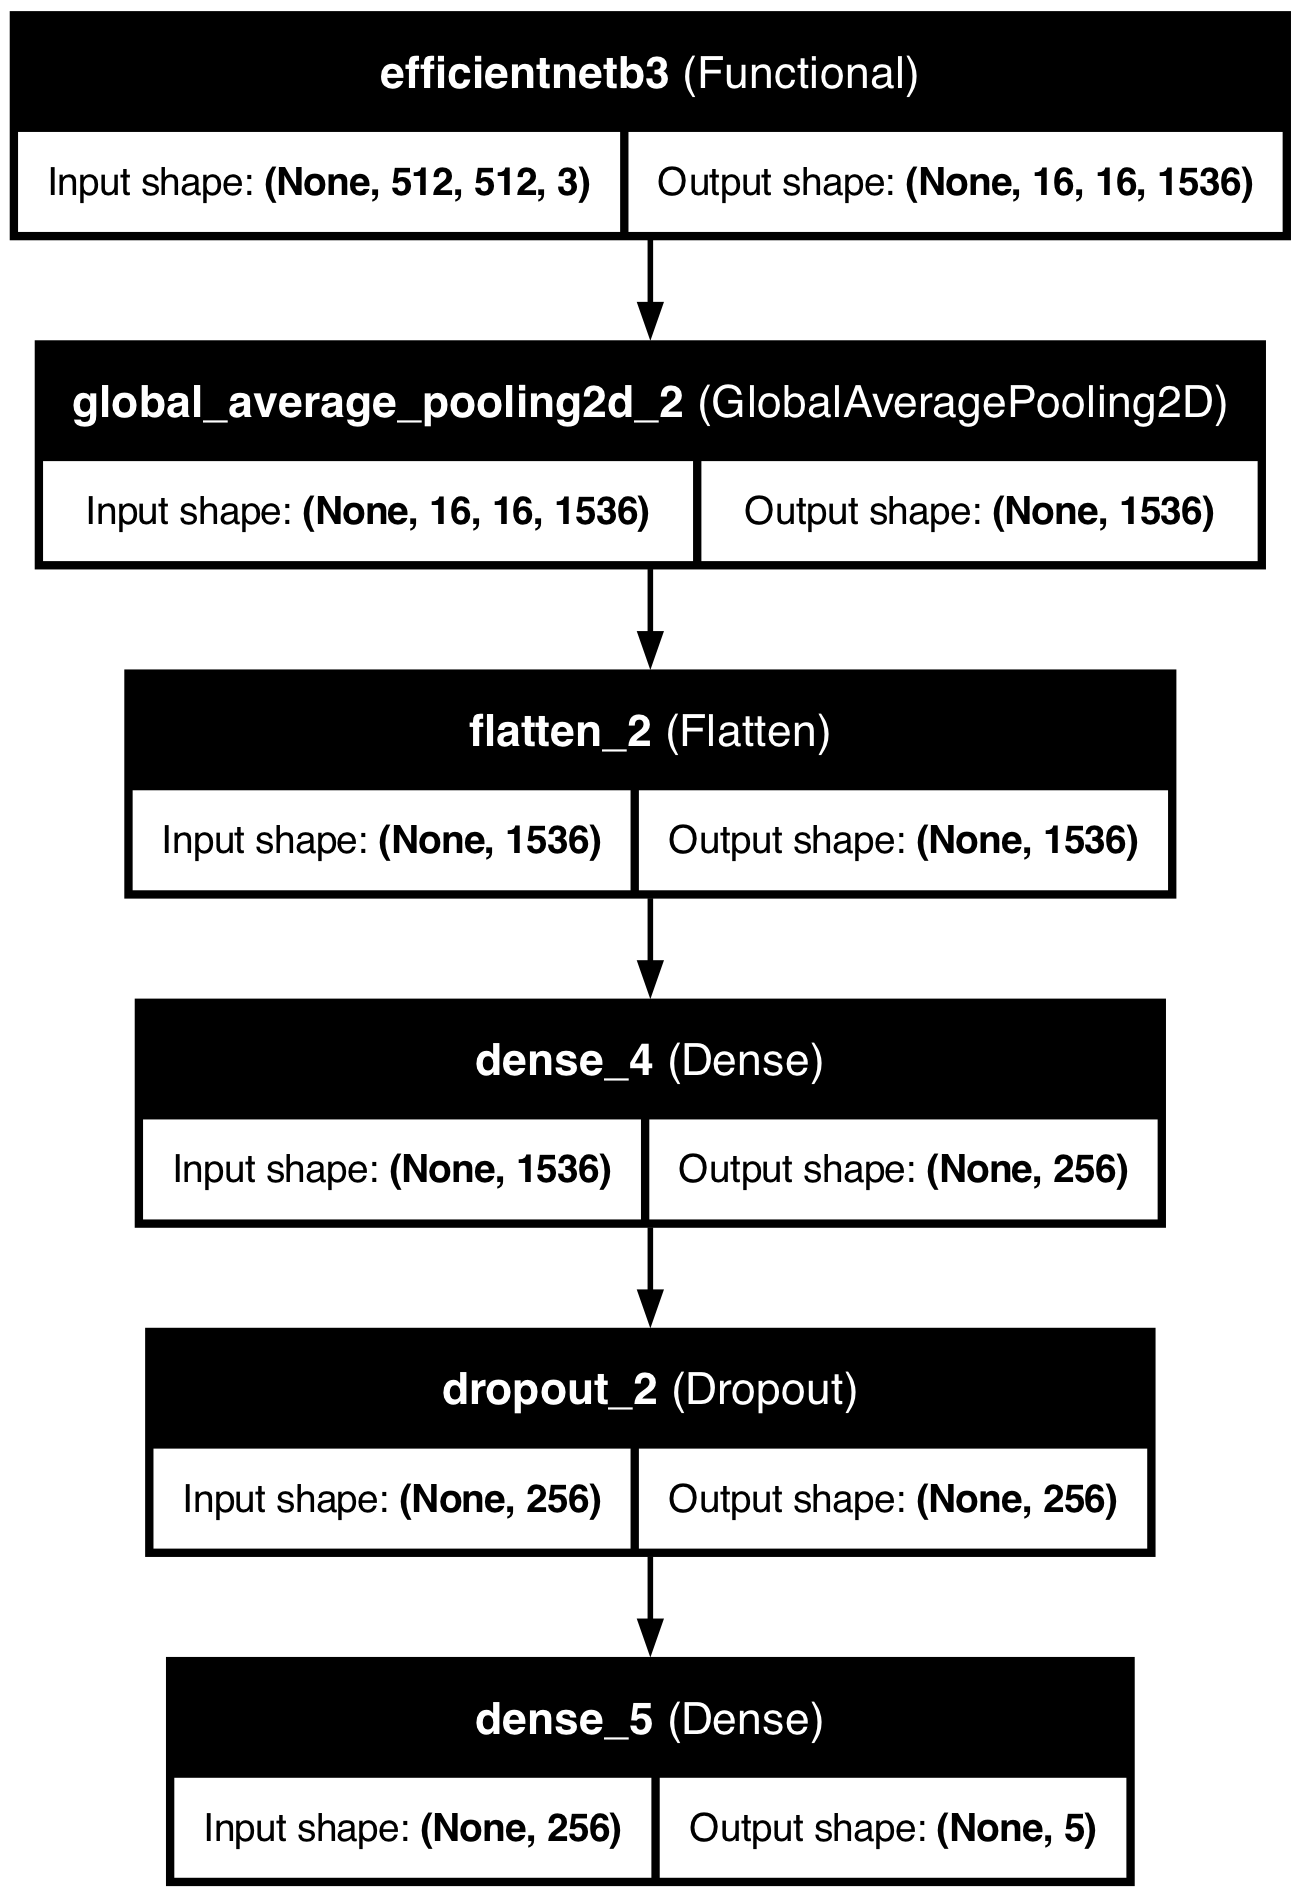

In [27]:
# === 模型构建 ===
def create_model():
    model = Sequential()
    model.add(EfficientNetB3(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
    ))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(
        256,
        activation='relu',
        bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

leaf_model = create_model()
leaf_model.summary()

# 画出网络结构图
keras.utils.plot_model(
    leaf_model,
    to_file='model_diagram_512.png',
    show_shapes=True,
    show_layer_names=True
)

In [28]:
# === 计算训练/验证/测试所需 step 数 ===
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VAL = validation_generator.n // validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

def model_fit():
    """编译并训练模型，并保存最优权重"""
    model = create_model()
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(
            from_logits=False,
            label_smoothing=0.0001,
            name='categorical_crossentropy'
        ),
        metrics=['categorical_accuracy']
    )
    
    # 回调
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint_cb = ModelCheckpoint(
        "Cassava_best_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_steps=STEP_SIZE_VAL,
        callbacks=[es, checkpoint_cb, reduce_lr],
    )
    
    # 训练结束后，保存最终模型
    model.save('Cassava_model.h5')
    return model, history

In [29]:
# === 检测 GPU ===
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# 如果想查看执行设备分配日志，可启用下面代码
# tf.debugging.set_log_device_placement(True)

# 示例操作，验证 TF 是否正常运算
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)
print("Matrix multiplication result:", c.numpy())


Num GPUs Available: 0
Matrix multiplication result: [[11.]]


In [15]:
import tensorflow as tf

# 打印是否检测到 GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# 打印使用了哪些设备
tf.debugging.set_log_device_placement(True)

# 示例操作
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)

print("Matrix multiplication result:", c)


Num GPUs Available: 0
Matrix multiplication result: tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [31]:
# === 加载或训练模型 ===
try:
    final_model = keras.models.load_model('Cassava_model.h5')
    print("已加载本地模型 Cassava_model.h5")
except Exception as e:
    print("未检测到已训练模型，开始训练...")
    with tf.device('/GPU:0'):  # 如果没有GPU，这里会自动切换到CPU
        final_model, results = model_fit()
    # 训练完成后，可查看最高训练集/验证集准确率
    print('Max Train Categorical Accuracy: ', 
          max(results.history['categorical_accuracy']))
    print('Max Val Categorical Accuracy: ', 
          max(results.history['val_categorical_accuracy']))

未检测到已训练模型，开始训练...
Epoch 1/15


KeyboardInterrupt: 

In [ ]:
# === 最终在测试集上评估 ===
test_loss, test_acc = final_model.evaluate(
    test_generator,
    steps=STEP_SIZE_TEST
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")